In [19]:
# Voeg imports toe als je ze nodig hebt
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import torch
import torchvision.io as tio
import matplotlib.pyplot as plt

%matplotlib inline


In [20]:
resizeshape = 224
mylearnrate = 0.001
batchsize = 32
mymomentum = 0.9
epochs = 100
optchoice = 'sgd'
generator1 = torch.Generator().manual_seed(42)

In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [22]:
# resize all the images in folder and subfolders ./apple_disease_classification/

import os

from PIL import Image, ImageOps

for subdir, dirs, files in os.walk('./Project 3/apple_cropped'):
    for file in files:
        filepath = subdir + os.sep + file

        # to-do pre-check for all image filetypes
        if filepath.endswith(".jpg") or filepath.endswith(".jpeg"):
            img = Image.open(filepath)
            if img.size != (resizeshape,resizeshape):
                # had to delete one because the jpg was not parseable somehow, blotch #17 is png ipv jpg look into it later
                rgb_im = img.convert('RGB')
                rgb_im_resized = rgb_im.resize(
                    (resizeshape, resizeshape))  # lets try 128x128
                rgb_im_resized.save(filepath)

                ## Quick way to augment dataset by flipping and mirroring
                rgb_im_flipped = ImageOps.flip(rgb_im_resized)
                rgb_im_mirrored = ImageOps.mirror(rgb_im_resized)

                # Modify the file path to include 'flipped' before the extension
                name, extension = os.path.splitext(filepath)
                flipped_filepath = name + '_flipped' + extension
                mirrored_filepath = name + '_mirrored' + extension

                # Save rgb_im_flipped with the new filename
                rgb_im_flipped.save(flipped_filepath)
                rgb_im_mirrored.save(mirrored_filepath)


In [23]:
# img = Image.open('./apple_disease_classification/Test/Blotch_Apple/120.jpg')
# img.size != (128,128)

In [24]:
dataset_path = "./apple_disease_classification/Train"


In [25]:
# get length of each folder in imagefolder dataset

import os

imagefolder = dataset_path

for folder in os.listdir(imagefolder):
    print(folder, len(os.listdir(os.path.join(imagefolder, folder))))


Blotch_Apple 345
Normal_Apple 199
Rot_Apple 342
Scab_Apple 255


In [26]:

#If our dataset is more similar to ImageNet dataset, we can use ImageNet mean and std. ImageNet mean and std are mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

from torchvision import transforms

transform_img_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5125,0.4667,0.4110],
                         std= [0.2621,0.2501,0.2453])
])

dataset = ImageFolder(dataset_path, transform=transform_img_normal)


In [27]:
dataset.class_to_idx


{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


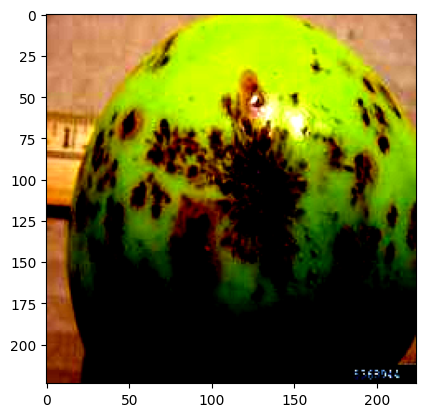

In [28]:
myimage, label = dataset[0]
plt.imshow(myimage.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


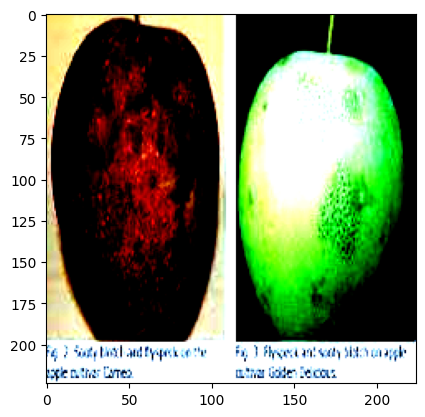

In [29]:
plt.imshow(dataset[1][0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Scab')

<Figure size 640x480 with 0 Axes>

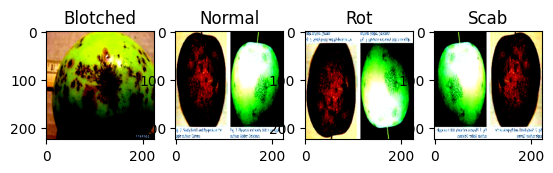

In [30]:

plt.figure()
f, axs = plt.subplots(1,4)
axs[0].imshow(dataset[0][0].permute(1,2,0))
axs[0].set_title('Blotched')
axs[1].imshow(dataset[1][0].permute(1,2,0))
axs[1].set_title('Normal')
axs[2].imshow(dataset[2][0].permute(1,2,0))
axs[2].set_title('Rot')
axs[3].imshow(dataset[3][0].permute(1,2,0))
axs[3].set_title('Scab')

In [31]:
# split in train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],generator=generator1)


In [32]:
batchsize = 40
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True, num_workers=2)  # numworkers parallel/subprocesses
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchsize, shuffle=False)  # no need to shuffle when evaluating


In [33]:
# -------------------------------------------------------
import torch.nn.functional as F
import random


class CNN(nn.Module):

    # -------------------------------------------------------

    def __init__(self):

        # Because we inherit from Module base class
        super().__init__()

        # RGB input, 6 filters, kernel of 5 x 5
        # initialise convolution but not execute
        self.conv1 = nn.Conv2d(3, 8, 5)

        # Filter is 2 x 2 with a stride of 2 (defined once, used two times)
        self.pool = nn.MaxPool2d(2, 2)

        # in_channels = 6 because self.conv1 output has 6 channels
        self.conv2 = nn.Conv2d(8, 16, 5)

        # Fully connected layer matched on output of conv2 layer
        # (64-5+1 = 60/2(pool) = 30-5+1 = 26/2 = 13)
        # (128-5+1 = 124/2(pool) = 62-5+1 = 58/2 = 29)
        # (224-5+1)= 220/2 = 110-5+1 = 106/2 = 53
        self.fc1 = nn.Linear(16 * 53 * 53, 256)
        
        # https://pure.tudelft.nl/ws/portalfiles/portal/72959187/1_s2.0_S1755534518300058_main.pdf
        # Based on our analyses we advise to use a minimum sample size of fifty times the number of weights in the neural network
        # but we only have 300 or so samples 300/50 = 6 weights xD
        # 2/3 * amount of input neurons in this case it would be: 2/3*224 = 150 neurons (lets take 128+32 = 160)
        # 2 hiddnelayers for discontinuous as network topology
        

        # Fully connected layer
        self.fc2 = nn.Linear(160, 80)

        # We have 10 labels
        self.fc3 = nn.Linear(80, 4)

        # initialize dropout of 20%
        self.drop1 = nn.Dropout(0.2)

    # -------------------------------------------------------
    def forward(self, x):

        # Convolution with relu layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # To match the output of the conv2 layer onto the first fully connected layer
        # Like reshape() but makes no copy (reuses underlaying data)

        # RuntimeError: shape '[-1, 400]' is invalid for input of size 173056 (x.shape = torch.Size([64, 16, 13, 13]) )
        # print('x.shape after pool-relu-conv2:', x.shape) = x.shape after pool-relu-conv2: torch.Size([64, 16, 13, 13])

        x = x.view(-1, 16 * 53 * 53)
        # Transfer from convolution to classification part:
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))

        # No activation on final layer
        return self.fc3(x)

# -------------------------------------------------------


In [34]:
import torch.optim as optim
myCNN = CNN().to(device)

CrossEntropyLossCriterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myCNN.parameters(), lr=mylearnrate, momentum=mymomentum)
#optimizer = optim.Adam(myCNN.parameters(), lr=mylearnrate)


In [35]:
# train_iter = iter(trainloader)
# images, labels = next(train_iter)
# images[1].shape


In [ ]:
# Train function

import realtime_graph as graph

epochresults = []
epoch_valloss = 0 
graph.startplot()

for epoch in range(epochs):
    
    running_loss = 0.0
    running_valloss = 0.0

    myCNN.train()
    for idx, data in enumerate(trainloader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        #-------------------------
        
        #forward pass
        outputs = myCNN.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        optimizer.step() # update weights based on learning rate and gradients
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)

    myCNN.eval() # prep model for evaluation
    epoch_vallos_previous = epoch_valloss
    for idx, data in enumerate(testloader):
        #forward pass
        outputs = myCNN.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        # record validation loss
        running_valloss += loss.item()
        

    epoch_valloss = running_valloss / len(testloader)


    epochresults.append([epoch_loss, epoch_valloss])

    
    graph.realtimeplot(epochresults)

        
    if epoch_vallos_previous-0.001 < epoch_valloss < epoch_vallos_previous+0.001:
        print("Early stopping")
        break

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

correct = 0
total = 0
confusion_matrix = np.zeros((4, 4))  # Initialize the confusion matrix

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for idx, data in enumerate(dataset_test_loader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        # ---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        # -------------------------

        # calculate outputs by running images through the network
        outputs = myCNN.forward(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update confusion matrix
        for i in range(len(labels)):
            confusion_matrix[labels[i]][predicted[i]] += 1

print(f'Accuracy of the network on the test images: {100 * correct // total} %')
print('Confusion Matrix:')
print(confusion_matrix)

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')
# from torchvision import models
# import numpy as np
# import cv2
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image, \
#     deprocess_image, \
#     preprocess_image
# from PIL import Image

# myCNN.eval()

# image_url = 'myapple_1.jpg'
# img = cv2.imread(image_url)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
# img = cv2.resize(img, (224, 224))
# img = np.float32(img) / 255
# input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# # The target for the CAM is the  'Normal_Apple': 1,
# # As usual for classication, the target is the logit output
# # before softmax, for that category.
# targets =  1
# target_layers = [myCNN.fc3]
# with GradCAM(model=myCNN, target_layers=target_layers, use_cuda=True) as cam:
#     grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
#     cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
# cam = np.uint8(255*grayscale_cams[0, :])
# cam = cv2.merge([cam, cam, cam])
# images = np.hstack((np.uint8(255*img), cam , cam_image))
# Image.fromarray(images)

In [ ]:
# maybe from around epoch 35-40 overfitting


In [ ]:
dataset_path_test = "./apple_disease_classification/Test"
transform = ToTensor()
dataset_test = ImageFolder(dataset_path, transform=transform)
dataset_test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=32, shuffle=False)


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for idx, data in enumerate(dataset_test_loader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        # ---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        # -------------------------

        # calculate outputs by running images through the network
        outputs = myCNN.forward(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    f'Accuracy of the network on the test images: {100 * correct // total} %')


In [ ]:
resnetmodel = torch.hub.load(
    "pytorch/vision", "resnet18", weights="IMAGENET1K_V1")
num_ftrs = resnetmodel.fc.in_features

# Here the size of each output sample is set to 4
resnetmodel.fc = nn.Linear(num_ftrs, 4)

# Check if output size is correct
resnetmodel.eval()


In [ ]:
# load to CUDA
myresnetmodel = resnetmodel.to(device)


In [ ]:
CrossEntropyLossCriterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myresnetmodel.parameters(), lr=mylearnrate, momentum=0.9)


In [ ]:
# Train function

from realtime_graph import realtimeplot
import gc

epochresults = []

for epoch in range(epochs):
    
    running_loss = 0.0

    for idx, data in enumerate(trainloader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        #-------------------------
        
        #forward pass
        outputs = myresnetmodel.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        #memory management: free up space
        del inputs, labels, outputs 
        torch.cuda.empty_cache()
        gc.collect()

        optimizer.step() # update weights based on learning rate and gradients
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    epochresults.append(epoch_loss)

    realtimeplot(epochresults)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for idx, data in enumerate(dataset_test_loader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        # ---load data into GPU----
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        # -------------------------

        # calculate outputs by running images through the network
        outputs = myresnetmodel.forward(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    f'Accuracy of the network on the test images: {100 * correct // total} %')


In [ ]:
# >>> from torchmetrics.classification import MulticlassConfusionMatrix
# >>> target = torch.tensor([2, 1, 0, 0])
# >>> preds = torch.tensor([
# ...   [0.16, 0.26, 0.58],
# ...   [0.22, 0.61, 0.17],
# ...   [0.71, 0.09, 0.20],
# ...   [0.05, 0.82, 0.13],
# ... ])
# >>> metric = MulticlassConfusionMatrix(num_classes=3)
# >>> metric(preds, target)
# tensor([[1, 1, 0],
#         [0, 1, 0],
#         [0, 0, 1]])

User story: Als gebruiker wil ik dat het systeem statistische gegevens van appel batches bijhoudt

In [ ]:
#Swin Transformer: image classification, 87.3 top-1 accuracy on ImageNet-1
transformersmodel = torch.hub.load(
    "pytorch/vision", "swin_t", weights="IMAGENET1K_V1")
# Check if output size is correct
transformersmodel.eval()

In [ ]:
in_features = transformersmodel.head.in_features
print(in_features)

In [ ]:
# Here the size of each output sample is set to 4
transformersmodel.head = nn.Linear(in_features, 4)

In [ ]:
transformersmodel.eval()

In [ ]:
# load to CUDA
transformersmodel = transformersmodel.to(device)

CrossEntropyLossCriterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(transformersmodel.parameters(), lr=mylearnrate, momentum=0.9)
epochs = 35

In [ ]:
# Train function

from realtime_graph import realtimeplot
import gc

epochresults = []

for epoch in range(epochs):
    
    running_loss = 0.0

    for idx, data in enumerate(trainloader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        #-------------------------
        
        #forward pass
        outputs = transformersmodel.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        #memory management: free up space
        del inputs, labels, outputs 
        torch.cuda.empty_cache()
        gc.collect()

        optimizer.step() # update weights based on learning rate and gradients
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    epochresults.append(epoch_loss)

    realtimeplot(epochresults)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for idx, data in enumerate(dataset_test_loader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        # ---load data into GPU----
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        # -------------------------

        # calculate outputs by running images through the network
        outputs = transformersmodel.forward(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    f'Accuracy of the network on the test images: {100 * correct // total} %')

In [ ]:
# # In Swin transformer base the output of the layers are typically BATCH x 49 x 1024. 
# # We can treat the last 49 elements as a 7x7 spatial image, with 1024 channels.
# # To reshape the activations and gradients to 2D spatial images, we can pass the CAM constructor a reshape_transform function.

# GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

# def reshape_transform(tensor, height=7, width=7):
#     result = tensor.reshape(tensor.size(0),
#         height, width, tensor.size(2))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result

# # Since the swin transformer is different from ViT, it does not contains cls_token as present in ViT, 
# # therefore we will use all the 7x7 images we get from the last block of the last layer

# target_layers = [model.layers[-1].blocks[-1].norm1]